# HW 11-1 Variational Autoencoder in 3D

三維呈現 VAE

---
(慣例的基本套件載入與資料讀取)

In [20]:
%env KERAS_BACKEND=tensorflow
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, FloatSlider

# Keras functions
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam, Adadelta
from keras import metrics

# Keras dataset
from keras.datasets import mnist

# Keras utilis function
from keras.utils import np_utils

from keras import backend as K

(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train/x_train.max()
x_test -= x_test.min()
x_test = x_test/x_test.max()

env: KERAS_BACKEND=tensorflow


## 建立模型

Encoder 使用的是兩層 Relu 的 fully connected NN：

In [21]:
x = Input(shape=(784,))
enc_1 = Dense(100, activation='relu')(x)
enc_x = Dense(16, activation='relu')(enc_1)
              
z_mean = Dense(3)(enc_x)
z_log_var = Dense(3)(enc_x)

這邊我把 Encoder 輸出的 dense 改成三維(畢竟想要嘗試三維呈現)，之後建立 decoder：

In [22]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(3,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(3,))([z_mean, z_log_var])

dec_2 = Dense(16, activation='relu')
dec_1 = Dense(100, activation='relu')
dec_0 = Dense(784, activation='relu')

dec_2z = dec_2(z)
dec_1z = dec_1(dec_2z)
x_hat = dec_0(dec_1z)

VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 100)          78500       input_4[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 16)           1616        dense_8[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 3)            51          dense_9[0][0]                    
__________________________________________________________________________________________________
dense_11 (

依照助教上課定義的 loss function：

In [23]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

compile 並訓練：

In [24]:
VAE.compile(loss=vae_loss, optimizer=Adadelta(lr = 1))
VAE.fit(x_train, x_train, batch_size = 32, epochs = 10)
# VAE = load_model('Data/model_11-1_HWP.h5')

Epoch 1/10
60000/60000 [==============================] - 19s 324us/step - loss: 413.1885
Epoch 2/10
60000/60000 [==============================] - 15s 252us/step - loss: 361.9229
Epoch 3/10
60000/60000 [==============================] - 22s 359us/step - loss: 354.1320
Epoch 4/10
60000/60000 [==============================] - 16s 266us/step - loss: 352.6538
Epoch 5/10
60000/60000 [==============================] - 13s 214us/step - loss: 347.8603
Epoch 6/10
60000/60000 [==============================] - 12s 200us/step - loss: 344.2389
Epoch 7/10
60000/60000 [==============================] - 12s 199us/step - loss: 333.5946
Epoch 8/10
60000/60000 [==============================] - 11s 177us/step - loss: 324.9756
Epoch 9/10
60000/60000 [==============================] - 11s 183us/step - loss: 323.5969
Epoch 10/10
60000/60000 [==============================] - 11s 186us/step - loss: 322.7723


把 Encoder 抽出來：

In [25]:
VAE_Encoder = Model(x, z_mean)
VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_9 (Dense)              (None, 16)                1616      
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 51        
Total params: 80,167
Trainable params: 80,167
Non-trainable params: 0
_________________________________________________________________


把 Decoder 抽出來：

In [26]:
h_input = Input(shape=(3,))
VAE_Decoder = Model(h_input, dec_0(dec_1(dec_2(h_input))))
VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                64        
_________________________________________________________________
dense_13 (Dense)             (None, 100)               1700      
_________________________________________________________________
dense_14 (Dense)             (None, 784)               79184     
Total params: 80,948
Trainable params: 80,948
Non-trainable params: 0
_________________________________________________________________


以上建模工作完成

## Encoder 呈現

先測試 Encoder 輸出是否如預期：

In [27]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, VAE_Encoder.predict(x_train[idx: idx+1])))

第 55818 圖的 latent 表示為 [[ 0.4451019   2.060294   -0.23282287]]


觀察 Encoder 的輸出狀況：

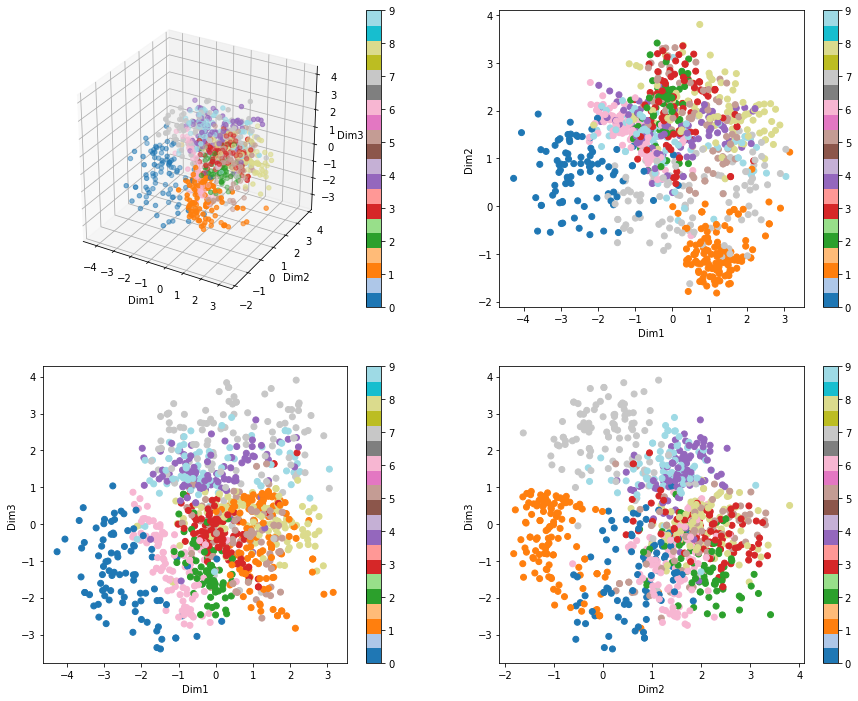

In [28]:
indices = np.random.randint(x_test.shape[0], size=1000)
VAE_latents = VAE_Encoder.predict(x_test[indices])

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(221, projection='3d')
im = ax.scatter(VAE_latents[:, 0],  VAE_latents[:, 1],  VAE_latents[:, 2],
           c=y_test0[indices], cmap='tab20')
ax.set_xlabel('Dim1')
ax.set_ylabel('Dim2')
ax.set_zlabel('Dim3')
fig.colorbar(im)

ax2 = fig.add_subplot(222)
im2 = ax2.scatter(VAE_latents[:, 0],  VAE_latents[:, 1],
                  c=y_test0[indices], cmap='tab20')
ax2.set_xlabel('Dim1')
ax2.set_ylabel('Dim2')
fig.colorbar(im2)

ax3 = fig.add_subplot(223)
im3 = ax3.scatter(VAE_latents[:, 0],  VAE_latents[:, 2],
                  c=y_test0[indices], cmap='tab20')
ax3.set_xlabel('Dim1')
ax3.set_ylabel('Dim3')
fig.colorbar(im3)

ax4 = fig.add_subplot(224)
im4 = ax4.scatter(VAE_latents[:, 1],  VAE_latents[:, 2],
                  c=y_test0[indices], cmap='tab20')
ax4.set_xlabel('Dim2')
ax4.set_ylabel('Dim3')
fig.colorbar(im4)

plt.show()

## Decoder 的呈現

由於 Decoder 的預測分布圖難以三維呈現，故第三個維度改可調整

In [29]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

def decoder_vis(zi):
    n = 13
    digit_size = 28

    grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
    grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)

    VAE_figure = np.zeros((digit_size * n, digit_size * n))

    for i, yi in enumerate(grid_x_vae):
        for j, xi in enumerate(grid_y_vae):
            z_sample = np.array([[xi, yi, zi]])
            x_decoded = VAE_Decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = normalized(digit)
            
    plt.figure(figsize=(10, 10))
    plt.imshow(VAE_figure, cmap='Greys')
    plt.axis('off')
    plt.show()
    
interact(decoder_vis, zi=FloatSlider(value=0, min=-4+0.05, max=4-0.05,
                                     step=0.1,))

interactive(children=(FloatSlider(value=0.0, description='zi', max=3.95, min=-3.95), Output()), _dom_classes=(…

<function __main__.decoder_vis(zi)>

## 動態呈現

In [75]:
def inBetween(t):
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]

    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 8))
    ax1 = plt.subplot(2, 1, 2, projection='3d')
    ax1.scatter(mu_0[0], mu_0[1], mu_0[2])
    ax1.scatter(mu_1[0], mu_1[1], mu_1[2])
    ax1.scatter(mu_t[0], mu_t[1], mu_t[2])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='hot')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')

互動

In [77]:
idx_1, idx_2 = np.random.randint(x_test.shape[0], size=2)
data_0 = x_train0[idx_1]
data_1 = x_train0[idx_2]

interact(inBetween, t=FloatSlider(value=0.5, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>

In [78]:
# 儲存訓練模型
from keras.models import load_model

VAE.save('Data/model_11-1_HWP.h5')